In [78]:
import numpy as np
import sbi 

# import lal as _lal
# from pycbc.waveform import get_fd_waveform
# from pycbc.psd import aLIGOZeroDetHighPower
# from pycbc.filter import highpass

import matplotlib
import matplotlib.pyplot as plt

import torch

from sbi import analysis as analysis
from sbi.analysis import pairplot
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform 
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from sbi.neural_nets import posterior_nn

#### (chatGPT) The noise:

detectore noise is given by:

$$n(f) - \mathbb{C} N(0,0.5S_n(f))$$

where $S_n(f)$ is the one-sided power spectral density at frequency f.

In [3]:
"""
theta[0]: mass1 (solar masses)
theta[1]: mass2 (solar masses)
theta[2]: distance (Mpc)
"""

# def simulator(theta):
#     delta_f = 1/16
#     f_lower = 20
#     f_final = 512
#     num_sim = theta.shape[0]
#     num_freq = int(((f_final - f_lower) / delta_f) + 1)
#     h_freq = np.zeros(shape = (num_sim, 4, num_freq))

#     # Calculate the gravitational wave strains in frequency space num_sim times
#     for i in range(num_sim):
#         mass1 = theta[i,0]
#         mass2 = theta[i,1]
#         distance = 10 ** theta[i,2]

        
#         hp, hc = get_fd_waveform(approximant="TaylorF2",
#                                  mass1=mass1,
#                                  mass2=mass2,
#                                  delta_f=delta_f,
#                                  f_lower=f_lower,
#                                  f_final=f_final,
#                                  distance=distance,
#                                  inclination=0.0,
#                                  coa_phase=0.0)
        
#         hp_freq = hp.to_frequencyseries()
#         frequencies = hp_freq.sample_frequencies.numpy()
#         hp_amplitudes = hp_freq.numpy()[frequencies >= f_lower]
#         hp_amplitudes_real = np.real(hp_amplitudes)
#         hp_amplitudes_imaginary = np.imag(hp_amplitudes)
        
#         hc_freq = hc.to_frequencyseries()
#         hc_amplitudes = hc_freq.numpy()[frequencies >= f_lower]
#         hc_amplitudes_real = np.real(hc_amplitudes)
#         hc_amplitudes_imaginary = np.imag(hc_amplitudes)
        
#         h_freq[i,0,:] = hp_amplitudes_real
#         h_freq[i,1,:] = hp_amplitudes_imaginary
#         h_freq[i,2,:] = hc_amplitudes_real
#         h_freq[i,3,:] = hc_amplitudes_imaginary
        
#         hp_psd = aLIGOZeroDetHighPower(length = len(frequencies), delta_f = delta_f, low_freq_cutoff = f_lower).numpy()[frequencies >= f_lower]
#         hp_scale = np.sqrt(0.5 * hp_psd * delta_f)
#         hp_noise_real = np.random.normal(0, hp_scale)
#         hp_noise_imaginary = np.random.normal(0, hp_scale)
        
#         hc_psd = aLIGOZeroDetHighPower(length = len(frequencies), delta_f = delta_f, low_freq_cutoff = f_lower).numpy()[frequencies >= f_lower]
#         hc_scale = np.sqrt(0.5 * hc_psd * delta_f)
#         hc_noise_real = np.random.normal(0, hc_scale)
#         hc_noise_imaginary = np.random.normal(0, hc_scale)
        
#         h_freq[i,0,:] += hp_noise_real
#         h_freq[i,1,:] += hp_noise_imaginary
#         h_freq[i,2,:] += hc_noise_real
#         h_freq[i,3,:] += hc_noise_imaginary

#     h_freq = h_freq.reshape(h_freq.shape[0],-1)

#     h_freq = torch.tensor(h_freq, dtype=torch.float32)
#     return h_freq
    
    

In [32]:
# mass1 = 1
# mass2 = 2
# distance = 500
# delta_f = 1/16
# f_lower = 20.0
# f_final = 512.0

# hp, hc = get_fd_waveform(approximant="TaylorF2",
#                              mass1=mass1,
#                              mass2=mass2,
#                              delta_f=delta_f,
#                              f_lower=f_lower,
#                              f_final=f_final,
#                              distance=distance,
#                              inclination=0.0,
#                              coa_phase=0.0)

# ht = hp.to_timeseries()
# times = ht.sample_times.numpy()
# amplitude = ht.numpy()

# plt.plot(times, amplitude)
# plt.xlabel("Time (s)")
# plt.ylabel("Strain h(t)")
# plt.savefig("time series")
# plt.close()

# hp_freq = hp.to_frequencyseries()
# frequencies = hp_freq.sample_frequencies.numpy()
# hp_amplitudes = hp_freq.numpy()
# hp_amplitudes_real = np.real(hp_amplitudes)
# hp_amplitudes_imaginary = np.imag(hp_amplitudes)

# hc_freq = hc.to_frequencyseries()
# hc_amplitudes = hc_freq.numpy()
# hc_amplitudes_real = np.real(hc_amplitudes)
# hc_amplitudes_imaginary = np.imag(hc_amplitudes)

# h_freq = np.zeros(shape = (4, len(frequencies)))
# h_freq[0,:] = hp_amplitudes_real
# h_freq[1,:] = hp_amplitudes_imaginary
# h_freq[2,:] = hc_amplitudes_real
# h_freq[3,:] = hc_amplitudes_imaginary

# hp_psd = aLIGOZeroDetHighPower(length = len(frequencies), delta_f = delta_f, low_freq_cutoff = f_lower)
# hp_scale = np.sqrt(0.5 * hp_psd.numpy() * delta_f)
# hp_noise_real = np.random.normal(0, hp_scale)
# hp_noise_imaginary = np.random.normal(0, hp_scale)

# hc_psd = aLIGOZeroDetHighPower(length = len(frequencies), delta_f = delta_f, low_freq_cutoff = f_lower)
# hc_scale = np.sqrt(0.5 * hc_psd.numpy() * delta_f)
# hc_noise_real = np.random.normal(0, hc_scale)
# hc_noise_imaginary = np.random.normal(0, hc_scale)

# h_freq[0,:] += hp_noise_real
# h_freq[1,:] += hp_noise_imaginary
# h_freq[2,:] += hc_noise_real
# h_freq[3,:] += hc_noise_imaginary

# plt.plot(frequencies, h_freq[0,:])
# plt.plot(frequencies, h_freq[1,:])
# plt.xlabel('frequency (Hz)')
# plt.ylabel('Strain amplitude h(f)')
# plt.savefig("frequency series hp + noise")
# plt.close()

# plt.plot(frequencies, h_freq[2,:])
# plt.plot(frequencies, h_freq[3,:])
# plt.xlabel('frequency (Hz)')
# plt.ylabel('Strain amplitude h(f)')
# plt.savefig("frequency series hc + noise")
# plt.close()

In [4]:
# theta = np.array([[30,30,np.log10(100)],
#                  [40,15,np.log10(200)],
#                  [50,25,np.log10(300)],
#                  [20,40,np.log10(400)],
#                  [35,20,np.log10(500)],])
# h_freq = simulator(theta)

In [5]:
# h_freq.shape

torch.Size([5, 31492])

In [6]:
delta_f = 1/16
f_lower = 20
f_final = 512
num_sim = 20000

# sim_wrapper = lambda theta: simulator(theta, delta_f = delta_f, f_lower = f_lower, f_final = f_final)
# def sim_wrapper(theta):
#     return simulator(theta = theta, delta_f = delta_f, f_lower = f_lower, f_final = f_final)

m_lowerbound = 5
m_upperbound = 10
log_dinstance_lowerbound = np.log10(100)
log_distance_upperbound = np.log10(300)

prior = BoxUniform(low=torch.tensor([m_lowerbound, m_lowerbound, log_dinstance_lowerbound]), 
                   high=torch.tensor([m_upperbound, m_upperbound, log_distance_upperbound]))

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

# Create inference object. Here, NPE is used.
inference = NPE(prior=prior, density_estimator="zuko_maf")

#generate simulations and pass to the inference object
theta, h_freq = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim)
inference = inference.append_simulations(theta, h_freq)

# train the density estimator and build the posterior
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)



  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 35 epochs.

In [14]:
theta_true = prior.sample((1,))
# generate our observation
h_obs = simulator(theta_true)

samples = loaded_posterior.sample((10000,), x=h_obs)

_ = analysis.pairplot(
    samples, 
    limits=[[m_lowerbound, m_upperbound], 
            [m_lowerbound, m_upperbound], 
            [log_dinstance_lowerbound, log_distance_upperbound]],
    figsize=(8, 8),
    labels=[r"$m_1$", r"$m_2$", r"$d$"],
    points=theta_true # add ground truth thetas,
)

plt.savefig("Gravitational Wave Posterior")
plt.close()

AssertionError: The trailing dimensions of `theta_or_x` do not match the `event_shape`.

In [12]:
torch.save(posterior, 'posterior.pt')

In [13]:
loaded_posterior = torch.load('posterior.pt')

/scratch-local/scur2965.11859728/ipykernel_3426891/3268222305.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_posterior = torch.load('posterior.pt')


In [66]:
prior.sample((1,))

tensor([[9.4523e-23, 2.6478e-01]])

### Simple sinus model with normalization, embedding network and custom neural network

#### Burst simulations by ligo

The expression for the taylorF2 approximant
\begin{align}
h(f) &= Af^{\frac{-7}{6}}e^{i\psi(f)}\\
\psi(f) &= 2\pi f t_c - \phi_c - \frac{\pi}{4} + \frac{3}{128\eta v^5}\sum^{N}_{k = 0} \psi_k v^k
\end{align}
<br>
$t_c$ is the coalescence time. In the context of gravitational wave signals from binary inspirals (e.g. black holes or neutron stars spiraling into each other), the coalescence time is the time it takes for two objects, like black holes or neutron stars, to merge due to the energy radiated away as gravitational waves. A is the amplitude prefactor that includes distance inclination.

\begin{equation}
h(f) = \mathcal{A}(f) e^{i \Psi(f)},
\end{equation}

where:
<p>- $\mathcal{A}(f)$ is the amplitude<p>
<p>-$\Psi(f)$ is the phase<p>


##### Amplitude $\mathcal{A}(f)$
The amplitude is:

\begin{equation}
\mathcal{A}(f) = \mathcal{A}_0 f^{-7/6},
\end{equation}

where:
\begin{equation}
\mathcal{A}_0 = \frac{1}{d_L} \sqrt{\frac{5}{24}} \frac{(G \mathcal{M}_c)^{5/6}}{\pi^{2/3} c^{3/2}},
\end{equation}

with:
<p>-$d_L$: Luminosity distance<p>
<p>-$\mathcal{M}_c = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}}$: Chirp mass<p>
<p>-$G$: Gravitational constant<p>
<p>-$c$: Speed of light<p>

\subsection*{Phase $\Psi(f)$}
The phase is a post-Newtonian expansion:

\begin{equation}
\Psi(f) = 2\pi f t_c - \phi_c - \frac{\pi}{4} + \frac{3}{128 (\pi f \mathcal{M}_c)^{5/3}} \sum_{k=0}^{N} \alpha_k (\pi f)^{k/3},
\end{equation}

where:
<p>-$t_c$: Coalescence time<p>
<p>-$\phi_c$: Coalescence phase<p>
<p>-$\alpha_k$: PN coefficients<p>

##### Post-Newtonian Coefficients (up to 3.5PN)
The non-spinning coefficients are:

\begin{align*}
\alpha_0 &= 1, \\
\alpha_1 &= 0, \\
\alpha_2 &= \frac{3715}{756} + \frac{55}{9} \eta, \\
\alpha_3 &= -16\pi + 4\beta, \\
\alpha_4 &= \frac{15293365}{508032} + \frac{27145}{504}\eta + \frac{3085}{72}\eta^2 - 10\sigma, \\
\alpha_5 &= \pi \left( \frac{38645}{756} - \frac{65}{9}\eta \right) (1 + \ln(\pi f)), \\
\alpha_6 &= \frac{11583231236531}{4694215680} - \frac{640}{3}\pi^2 - \frac{6848}{21}\gamma_E \\
&\quad + \left( \frac{2255\pi^2}{12} - \frac{15737765635}{3048192} \right)\eta \\
&\quad + \frac{76055}{1728}\eta^2 - \frac{127825}{1296}\eta^3 - \frac{6848}{21} \ln(4\pi f), \\
\alpha_7 &= \pi \left( \frac{77096675}{254016} + \frac{378515}{1512}\eta - \frac{74045}{756}\eta^2 \right),
\end{align*}

where $\eta = \frac{m_1 m_2}{(m_1 + m_2)^2}$ is the symmetric mass ratio, $\beta$ is the spin-orbit parameter, $\sigma$ is the spin-spin parameter, and $\gamma_E$ is the Euler-Mascheroni constant.

##### Complete Expression
The full TaylorF2 waveform is:

\begin{equation}
h(f) = \mathcal{A}_0 f^{-7/6} \exp\left[ i \left( 2\pi f t_c - \phi_c - \frac{\pi}{4} + \frac{3}{128 (\pi f \mathcal{M}_c)^{5/3}} \sum_{k=0}^{N} \alpha_k (\pi f)^{k/3} \right) \right].
\end{equation}



So our simplified model will be
\begin{align}
h(f) &= Af^{\frac{-7}{6}}e^{2i\pi f t_c}\\
\end{align}

<!-- \begin{align}
h(t) &= h_0 e^{\frac{-t}{\tau}}sin(2\pi f_0 t)
h(f) &= 
\end{align} -->

#### Problem normalization data

For low values of A ($A \approx 10^{-22}$) the posterior couldnt create samples, for values of A around 1 this did work. So we need to normalize the data so we can do a succesfull interference on models with realistice values for the parameters. When doing the normalization we want to make sure the waves still retain their structure, otherwise the interference cant distiguise the different cases. 

#### Problem normalizing parameters

SBI interference, or any ML interference in general, has a problem when the scale of the parameters are different by a substential amount, so they need normalized. I did it by taking the prior over the log of the amplitude. 

In [198]:
# take real part 
def simulator(theta):
    # theta = [A, t_c]
    f_lower = 20
    f_final = 40
    delta_f = 1/16
    n_freq = int(np.round((f_final - f_lower) / delta_f + 1,0))
    
    num_sim = theta.shape[0]
    #print(theta)

    f_array = np.linspace(f_lower, f_final, n_freq)
    h_freq = np.zeros(shape = (num_sim, len(f_array)))
    for i in range(num_sim):
        Alog = theta[i,0].numpy()
        A = 10 ** Alog
        tc = theta[i,1].numpy()
        
        #print(tc, tc.type())
        
        h_freq[i,:] = (A * f_array ** (-7/6) * np.e ** (2j * np.pi * f_array * tc)).real
    
    h_freq = torch.tensor(h_freq, dtype=torch.float32)
    return h_freq

# normalization for every frequency
def normalize(h_freq):
    mean = h_freq.mean(dim=0, keepdim=True)  # Mean per frequency bin
    std = h_freq.std(dim=0, keepdim=True)   # Std per frequency bin
    h_freq_normalized = (h_freq - mean) / (std)
    return h_freq_normalized, mean, std   

# global normalization
def normalize_(h_freq):
    mean = h_freq.mean() 
    std = h_freq.std()
    h_freq_normalized = (h_freq - mean) / (std)
    return h_freq_normalized, mean, std 

def normalize_obs(h_obs, mean, std):
    h_obs_normalized = (h_obs - mean) / (std)
    return h_obs_normalized

In [211]:
num_sim = 2000
Alog_lowerbound = 0
Alog_upperbound = 1
tc_lowerbound = 0.1
tc_upperbound = 0.5

prior = BoxUniform(low=torch.tensor([Alog_lowerbound, tc_lowerbound]), 
                   high=torch.tensor([Alog_upperbound, tc_upperbound]))

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

# Create inference object. Here, NPE is used.
#custom_density_estimator = posterior_nn(model = 'zuko_maf', hidden_features = [64]*3, num_transforms = 5)

inference = NPE(prior=prior, density_estimator='zuko_maf', transform = Star)

# #generate simulations and pass to the inference object
# theta, h_freq = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim)
# inference = inference.append_simulations(theta, h_freq)
theta_prior = prior.sample((num_sim,))
h_sim = simulator(theta_prior)
#h_sim_normalized, mean, std = normalize_(h_sim)

#inference = inference.append_simulations(theta_prior, h_sim_normalized)
inference = inference.append_simulations(theta_prior, h_sim)

# # train the density estimator and build the posterior
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)


 Neural network successfully converged after 94 epochs.


Drawing 10000 posterior samples: 100%|████████████████████████████████████████| 10000/10000 [00:00<00:00, 67620.83it/s]


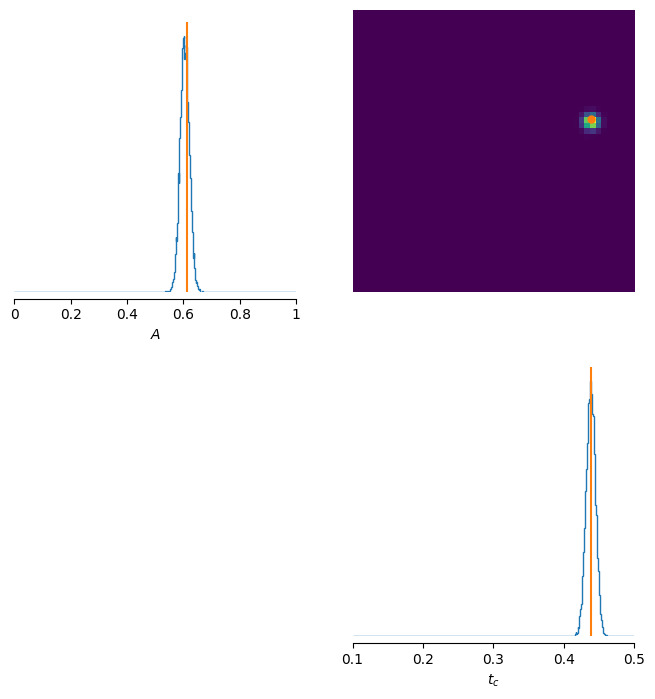

In [213]:
theta_true = prior.sample((1,))
# generate our observation
h_obs = simulator(theta_true)
#h_obs_normalized = normalize_obs(h_obs, mean, std)

#samples = posterior.sample((10000,), x=h_obs_normalized)
samples = posterior.sample((10000,), x=h_obs)

_ = analysis.pairplot(
    samples, 
    limits=[[Alog_lowerbound, Alog_upperbound], 
            [tc_lowerbound, tc_upperbound]],
    figsize=(8, 8),
    labels=[r"$A$", r"$t_c$"],
    points=theta_true # add ground truth thetas,
)

# plt.savefig("Gravitational Wave Posterior")
# plt.close()

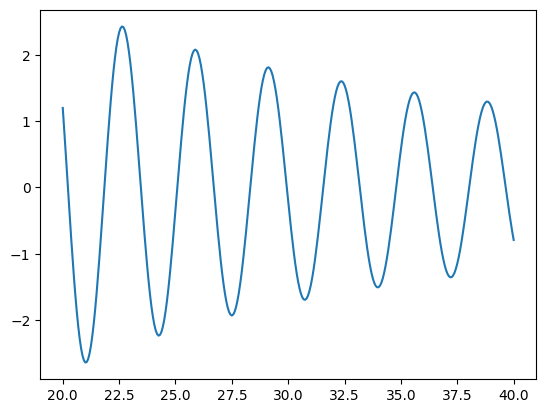

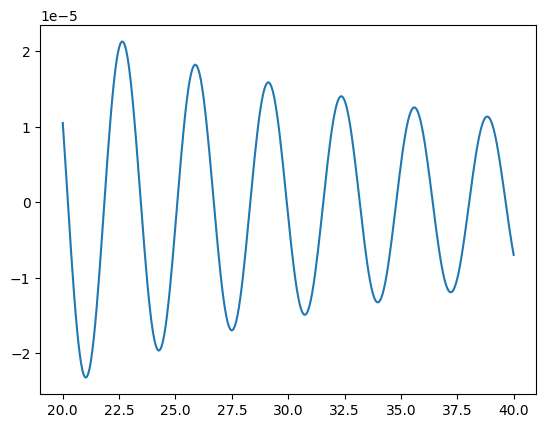

In [197]:
f_lower = 20
f_final = 40
delta_f = 1/16
n_freq = int(np.round((f_final - f_lower) / delta_f + 1,0))

f_array = np.linspace(f_lower, f_final, n_freq)

plt.plot(f_array, h_obs_normalized[0,:])
plt.show()
plt.plot(f_array, h_obs[0,:])
plt.show()

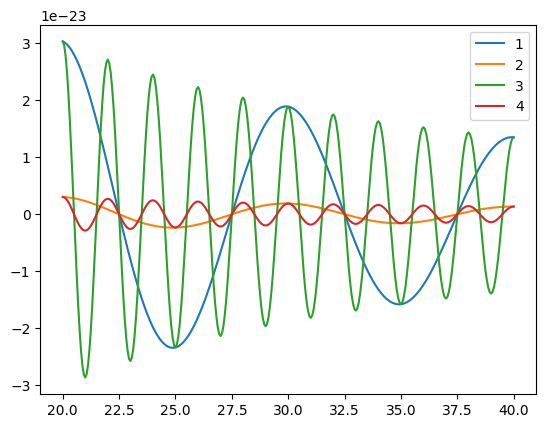

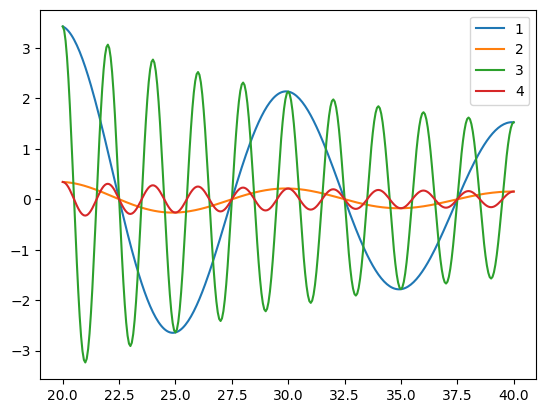

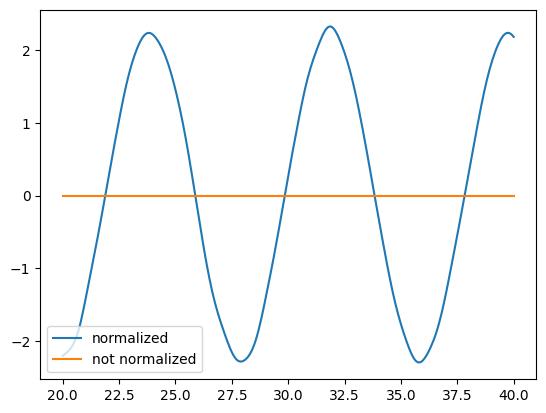

In [183]:
f_array = np.linspace(f_lower, f_final, n_freq)

theta_prior = prior.sample((num_sim,))
theta_prior[:4,:] = torch.tensor([[10 ** (-21),0.1],
                                  [10 ** (-22),0.1],
                                  [10 ** (-21),0.5],
                                  [10 ** (-22),0.5]])

h = simulator(theta_prior)
h_normalized, mean, std = normalize_(h)

plt.plot(f_array, h[0,:], label = '1')
plt.plot(f_array, h[1,:], label = '2')
plt.plot(f_array, h[2,:], label = '3')
plt.plot(f_array, h[3,:], label = '4')
plt.legend()
plt.show()

plt.plot(f_array, h_normalized[0,:], label = '1')
plt.plot(f_array, h_normalized[1,:], label = '2')
plt.plot(f_array, h_normalized[2,:], label = '3')
plt.plot(f_array, h_normalized[3,:], label = '4')
plt.legend()
plt.show()

plt.plot(f_array, h_obs_normalized[0,:], label = 'normalized')
plt.plot(f_array, h_obs[0,:], label = 'not normalized')
plt.legend()
plt.show()

In [184]:
h_normalized

tensor([[ 3.4248,  3.4098,  3.3895,  ...,  1.5267,  1.5275,  1.5259],
        [ 0.3430,  0.3414,  0.3394,  ...,  0.1531,  0.1532,  0.1531],
        [ 3.4248,  3.3468,  3.1413,  ...,  1.4149,  1.4993,  1.5259],
        ...,
        [ 1.1320,  0.7703,  0.3959,  ..., -0.5074, -0.6565, -0.7920],
        [ 0.7476,  1.2022,  1.6256,  ..., -1.3915, -1.3361, -1.2497],
        [ 0.7293,  0.6884,  0.6381,  ...,  0.3075,  0.2851,  0.2588]])

In [185]:
mean

tensor(-4.6028e-27)

In [186]:
std

tensor(8.8626e-24)

In [93]:
h_freq = h_sim

In [94]:
mean = h_freq.mean(dim=0, keepdim=True)  # Mean per frequency bin
std = h_freq.std(dim=0, keepdim=True)   # Std per frequency bin
h_freq_normalized = (h_freq - mean) / (std + 1e-8)

In [102]:
h_freq[:,1].numpy().mean()

np.float32(0.0001605674)

In [97]:
h_freq.shape

torch.Size([2000, 321])

In [103]:
mean.shape

torch.Size([1, 321])

In [111]:
((h_freq[0,:] - mean) / std).numpy().mean()

np.float32(-0.037261486)

In [113]:
h_freq_normalized[:,0].std()

tensor(1.0000)

In [84]:
h_obs.shape

torch.Size([1, 321])

In [52]:
theta_true = prior.sample((1,))
# generate our observation
h_obs = simulator(theta_true)

In [53]:
h_obs

tensor([[ 1.8152e-13,  5.1646e-13,  8.3705e-13,  1.1360e-12,  1.4065e-12,
          1.6426e-12,  1.8390e-12,  1.9916e-12,  2.0970e-12,  2.1533e-12,
          2.1593e-12,  2.1155e-12,  2.0230e-12,  1.8845e-12,  1.7034e-12,
          1.4841e-12,  1.2321e-12,  9.5341e-13,  6.5457e-13,  3.4266e-13,
          2.4965e-14, -2.9113e-13, -5.9834e-13, -8.8964e-13, -1.1584e-12,
         -1.3986e-12, -1.6048e-12, -1.7726e-12, -1.8982e-12, -1.9792e-12,
         -2.0138e-12, -2.0017e-12, -1.9434e-12, -1.8406e-12, -1.6959e-12,
         -1.5130e-12, -1.2962e-12, -1.0510e-12, -7.8303e-13, -4.9872e-13,
         -2.0472e-13,  9.2110e-14,  3.8490e-13,  6.6691e-13,  9.3170e-13,
          1.1733e-12,  1.3862e-12,  1.5657e-12,  1.7078e-12,  1.8096e-12,
          1.8690e-12,  1.8847e-12,  1.8568e-12,  1.7861e-12,  1.6746e-12,
          1.5250e-12,  1.3412e-12,  1.1274e-12,  8.8897e-13,  6.3140e-13,
          3.6082e-13,  8.3556e-14, -1.9395e-13, -4.6528e-13, -7.2421e-13,
         -9.6482e-13, -1.1817e-12, -1.

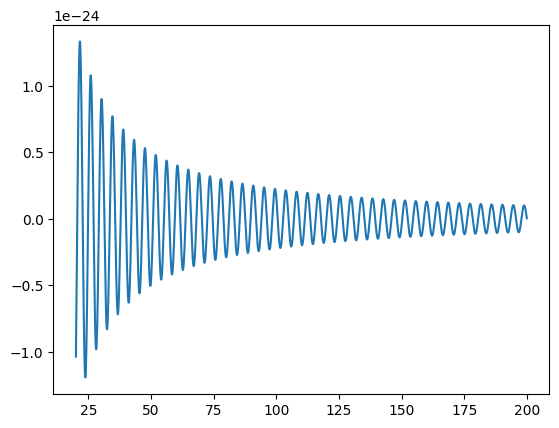

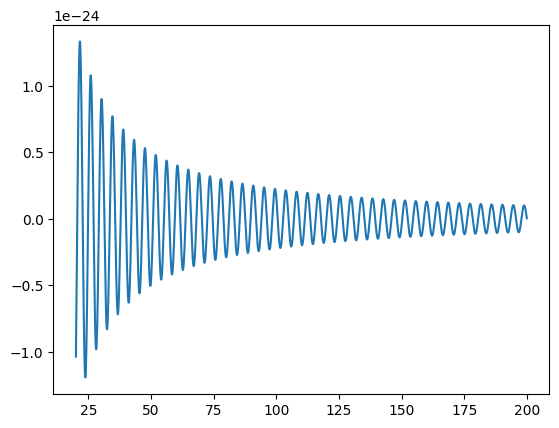

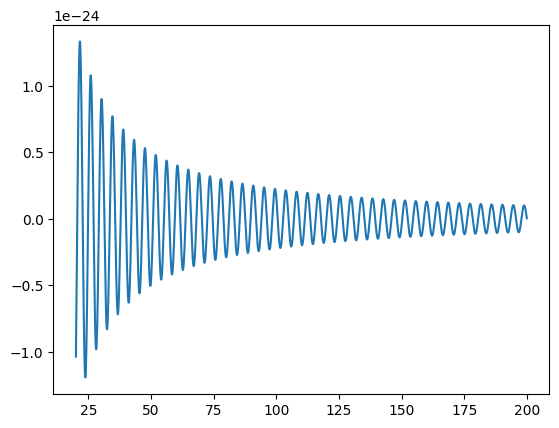

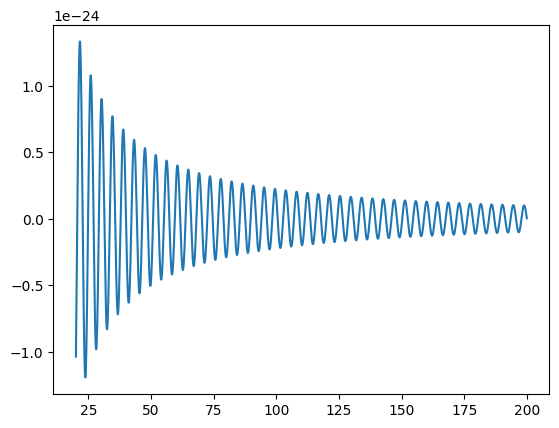

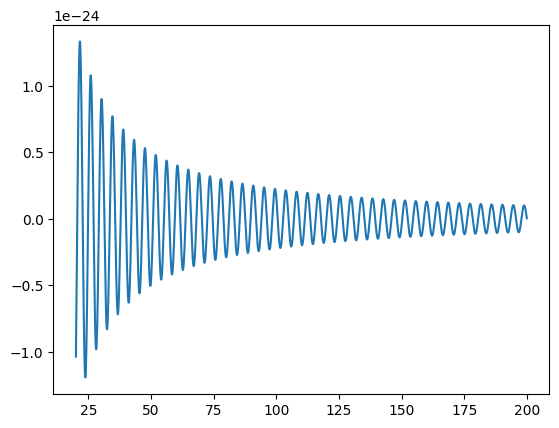

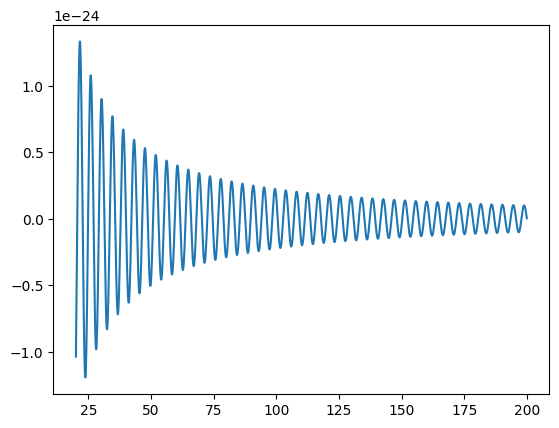

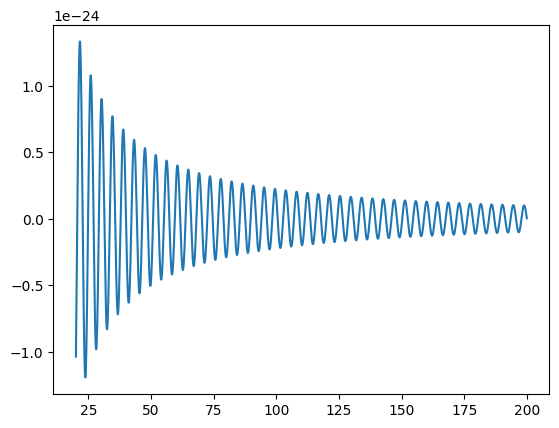

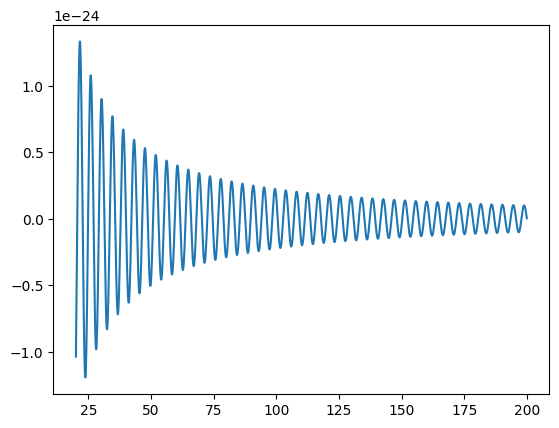

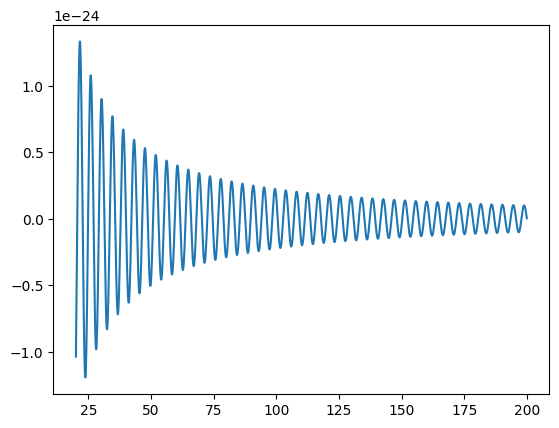

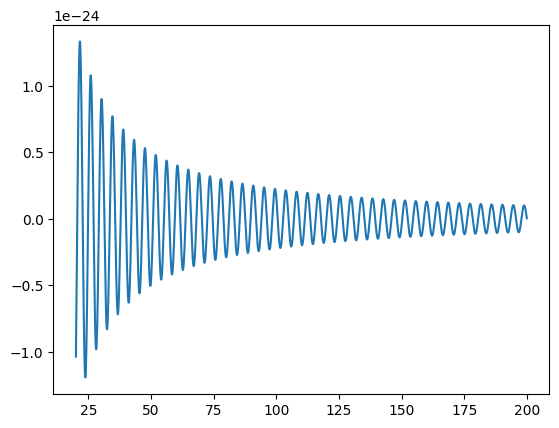

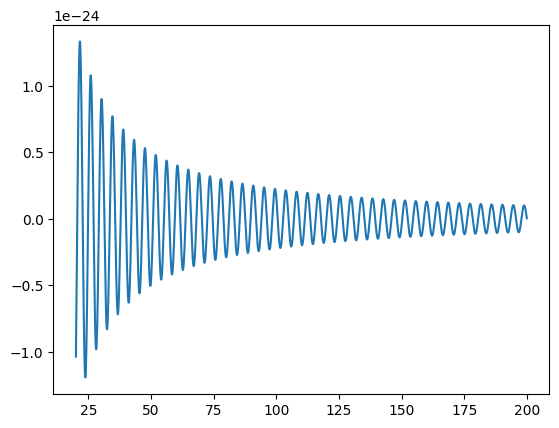

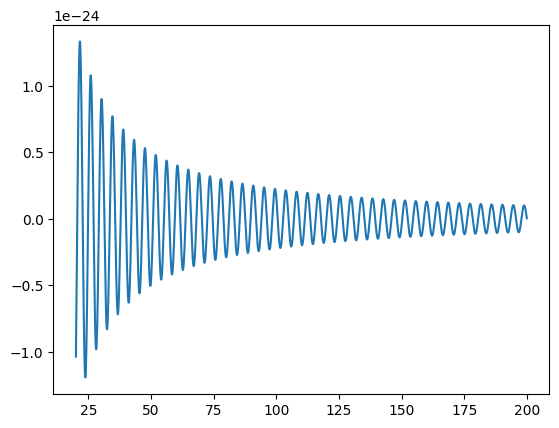

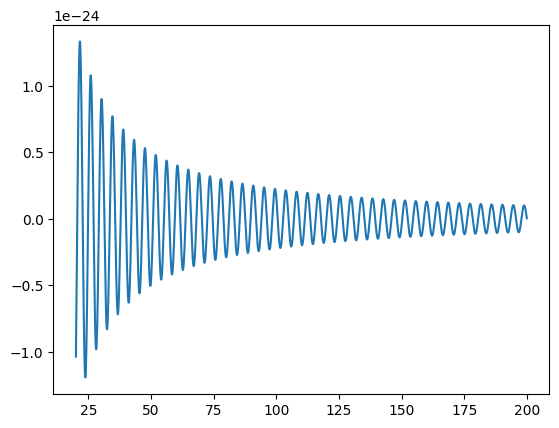

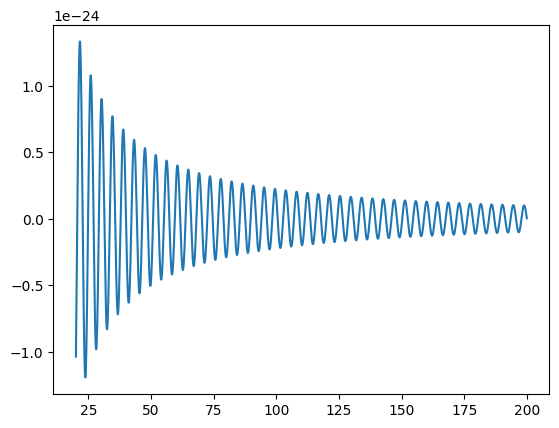

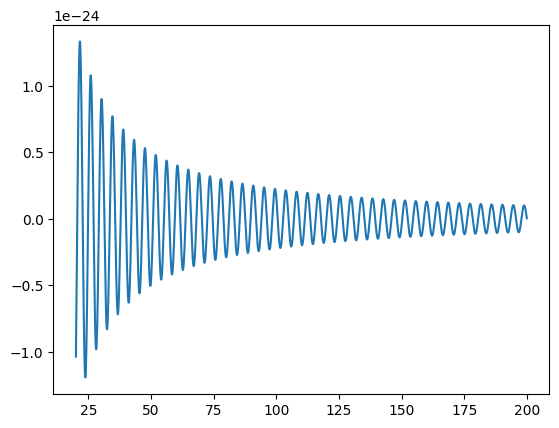

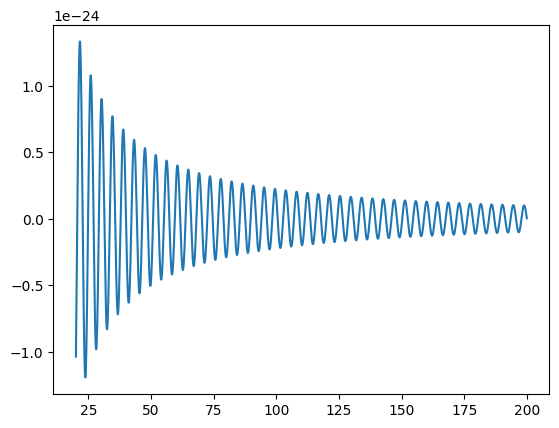

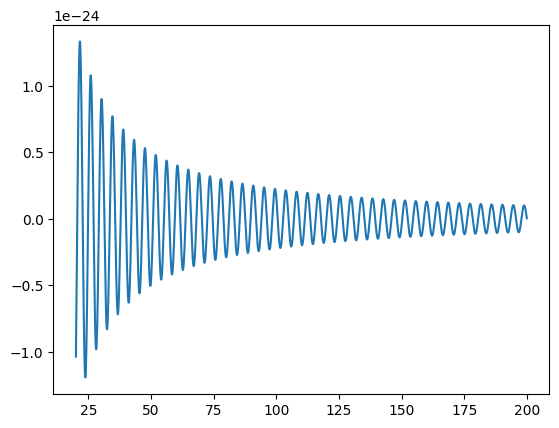

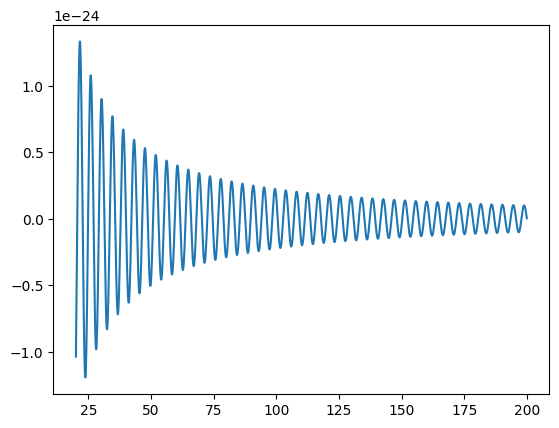

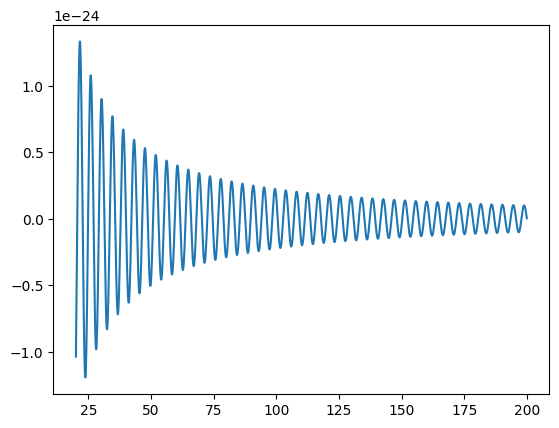

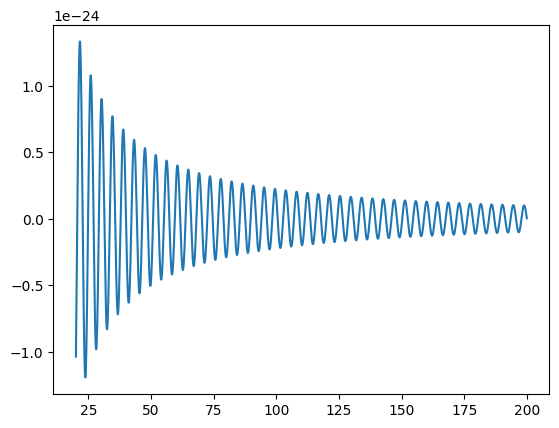

In [27]:
for sim in range(num_sim):
    plt.plot(f_array, h_freq[0,:])
    plt.show()

In [25]:
f_lower = 20
f_final = 200
delta_f = 1/16

f_array = np.arange(f_lower, f_final + delta_f, delta_f)

In [8]:
f_array

array([ 20.    ,  20.0625,  20.125 , ..., 199.875 , 199.9375, 200.    ],
      shape=(2881,))

In [9]:
np.e ** (f_array)

array([4.85165195e+08, 5.16455662e+08, 5.49764191e+08, ...,
       6.37689947e+86, 6.78817415e+86, 7.22597377e+86], shape=(2881,))

In [32]:
num_sim = 1

A = 10 ** (-22)
psi = 0.5
f_array = np.arange(f_lower, f_final + delta_f, delta_f)
h_freq = np.zeros(shape = (num_sim, len(f_array)))

for i in range(num_sim):
#     A = theta[i,0]
#     tc = theta[i,1]

    h_freq[i,:] = (A * f_array ** (-7/6) * np.e ** (2j * np.pi * f_array * t_c)).real

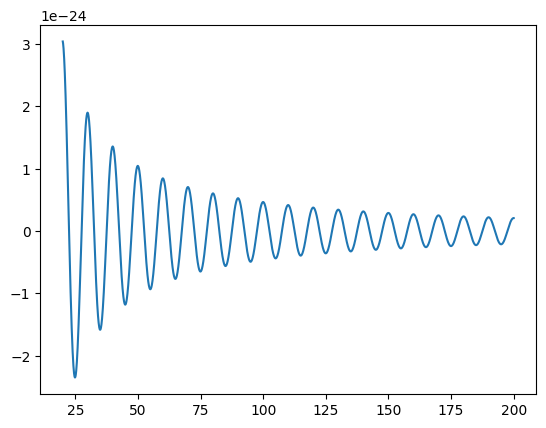

In [33]:
plt.plot(f_array, h_freq[0,:])

In [16]:
h_f = A * f_array ** (-7/6) * np.e ** (2j * np.pi * f_array * t_c)

In [17]:
h_f.real

array([3.03481116e-24, 2.79361222e-24, 2.13039335e-24, ...,
       1.46307564e-25, 1.91090331e-25, 2.06759277e-25], shape=(2881,))

In [18]:
h_f

array([3.03481116e-24-1.48662871e-38j, 2.79361222e-24+1.15715207e-24j,
       2.13039335e-24+2.13039335e-24j, ...,
       1.46307564e-25-1.46307564e-25j, 1.91090331e-25-7.91522067e-26j,
       2.06759277e-25+1.62462072e-39j], shape=(2881,))

In [40]:
custom_density_estimator = posterior_nn(model = 'zuko_maf', hidden_features = [64]*3, num_transforms = 5)

In [41]:
custom_density_estimator.

<function sbi.neural_nets.factory.posterior_nn.<locals>.build_fn(batch_theta, batch_x)>